<a href="https://colab.research.google.com/github/manelreghima/Hurricanes-track/blob/main/Hurricanes_track.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction:**

The intensity of a hurricane is measured by the Saffir-Simpson Hurricane Wind Scale.

This rates the storms from one to five based on sustained wind speed and the potential property damage those winds can cause. 

**Task:**

Train a forecaster that predicts hurricanes track 24 hours ahead in time (latitude and longitude).

Training data: before 2021
Test data: hurricanes in North Atlant 2021

Calculate mean absolute error for your 24h prediction in kilometers for the test set.

Training and test data can be found here:
https://www.ncdc.noaa.gov/ibtracs/index.php?name=ib-v4-access


#Setup


In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.3 MB/s 
     |████████████████████████████████| 16.7 MB 31.6 MB/s 
     |████████████████████████████████| 6.3 MB 16.6 MB/s 


In [ ]:
!pip install cartopy

     |████████████████████████████████| 10.8 MB 7.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 21.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 32.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 24.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 3.0 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516300 sha256=d137273ff4126d5f64671922aa3957308bddd1354ae6d0c8ad815fb900d6d8db
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
Successfully built cartopy


In [ ]:
# importing the required library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px 
import geopandas as gpd


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from datetime import datetime,date

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math 
from statistics import mean


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#data exploration

In [ ]:
df = pd.read_csv('/content/ibtracs.NA.list.v04r00.csv')

In [ ]:
df.head(3)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,...,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,kts,mb,,,km,km,,,,degrees_north,degrees_east,,,kts,mb,1,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,nmile,mb,nmile,...,degrees_east,kts,mb,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,kts,mb,nmile,degrees_north,degrees_east,,kts,mb,degrees_north,degrees_east,,kts,mb,kts,kts,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,,,,main,335,323,_____________O,,,,,,,,,-5,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,26.1000,-90.4000,TD,30,,,,,,,,,,,,6,291
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,,,,main,323,312,_____________P,,,,,,,,,-5,,,,,,,,,,,,,,,...,,,,,,,,,,,,,,,,,,,,,,,,26.2001,-90.6999,TD,30,,,,,,,,,,,,6,290


In [ ]:
df.dtypes

SID              object
SEASON           object
NUMBER           object
BASIN            object
SUBBASIN         object
                  ...  
USA_SEARAD_SE    object
USA_SEARAD_SW    object
USA_SEARAD_NW    object
STORM_SPEED      object
STORM_DIR        object
Length: 163, dtype: object

 ▶ The first line contains the unit of measure ➡ to drop

 ▶ Scrolling the see the different values for a given row, we find that there are many empty cells (probably missing values) 
 
 ➡ to explore further

In [ ]:
df.shape

(124139, 163)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124139 entries, 0 to 124138
Columns: 163 entries, SID to STORM_DIR
dtypes: int64(1), object(162)
memory usage: 154.4+ MB


In [ ]:
df.describe()

,USA_SSHS
count,124139.000000
mean,-1.024118
std,2.432623
min,-5.000000
25%,-3.000000
50%,0.000000
75%,0.000000
max,5.000000


▶ We have one numeric column amoth the 163 columns.

**▶Information about USA_SSHS:**

Saffir-Simpson Hurricane Scale information based on the wind speed provided by the US agency
wind speed (US agencies provide 1-minute wind speeds)



In [ ]:
df.columns

Index(['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME',
       'NATURE', 'LAT', 'LON',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=163)

In [ ]:
df.isnull().sum()

SID                   0
SEASON                0
NUMBER                0
BASIN            123617
SUBBASIN          94476
                  ...  
USA_SEARAD_SE         0
USA_SEARAD_SW         0
USA_SEARAD_NW         0
STORM_SPEED           0
STORM_DIR             0
Length: 163, dtype: int64

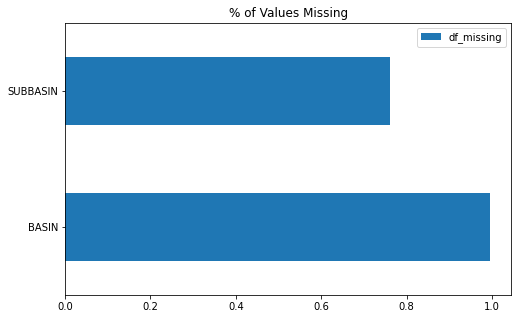

In [ ]:
#exploring columns having missing values

ncounts = pd.DataFrame([df.isna().mean()]).T
ncounts
ncounts = ncounts.rename(columns={0: "df_missing"})

ncounts.query("df_missing > 0").plot(
    kind="barh", figsize=(8, 5), title="% of Values Missing"
)
plt.show()

*BASIN* Basin of the current storm position

*SUBBASIN* Sub-basin of the current storm position


Basins and subbasins include:

NA - North Atlantic
EP - Eastern North Pacific
WP - Western North Pacific
NI - North Indian
SI - South Indian
SP - Southern Pacific
SA - South Atlantic


In [ ]:
df.BASIN.value_counts()

EP    503
NI     18
        1
Name: BASIN, dtype: int64

In [ ]:
df.SUBBASIN.value_counts()

CS    15497
GM    13644
MM      503
AS       18
          1
Name: SUBBASIN, dtype: int64

Conclusion :

▶ Basin is a column filled with 90% of NaNs 

▶ Subbasin is a column filled with 77% of NaNs

They cannot hold valuable information ➡ drop them.

#Data Preprocessing

In [ ]:
#Drop the 2 columns full of NaNs
df.drop(['BASIN', 'SUBBASIN'], axis = 1, inplace = True) 


In [ ]:
#drop the first line containing the units of measures
df.drop(index=0, inplace = True)

In [ ]:
my_dict={}
for col in df.columns :
  df_result=df.query( col+" == ' '")
  count=df_result.shape[0]
  my_dict[col]=count/df.shape[0]




In [ ]:
my_dict2 = { key: value for key, value in my_dict.items() if value == 1 }
my_dict3 = { key: value for key, value in my_dict.items() if value >= 0.7}
values = my_dict3.values()
keys = my_dict3.keys()
print('Count of the columns having all empty values :',len(my_dict2))
print('Count of the columns having the count of its empty values >= 0.7  :',len(my_dict3))


Count of the columns having all empty values : 99
Count of the columns having the count of its empty values >= 0.7  : 137


<BarContainer object of 137 artists>

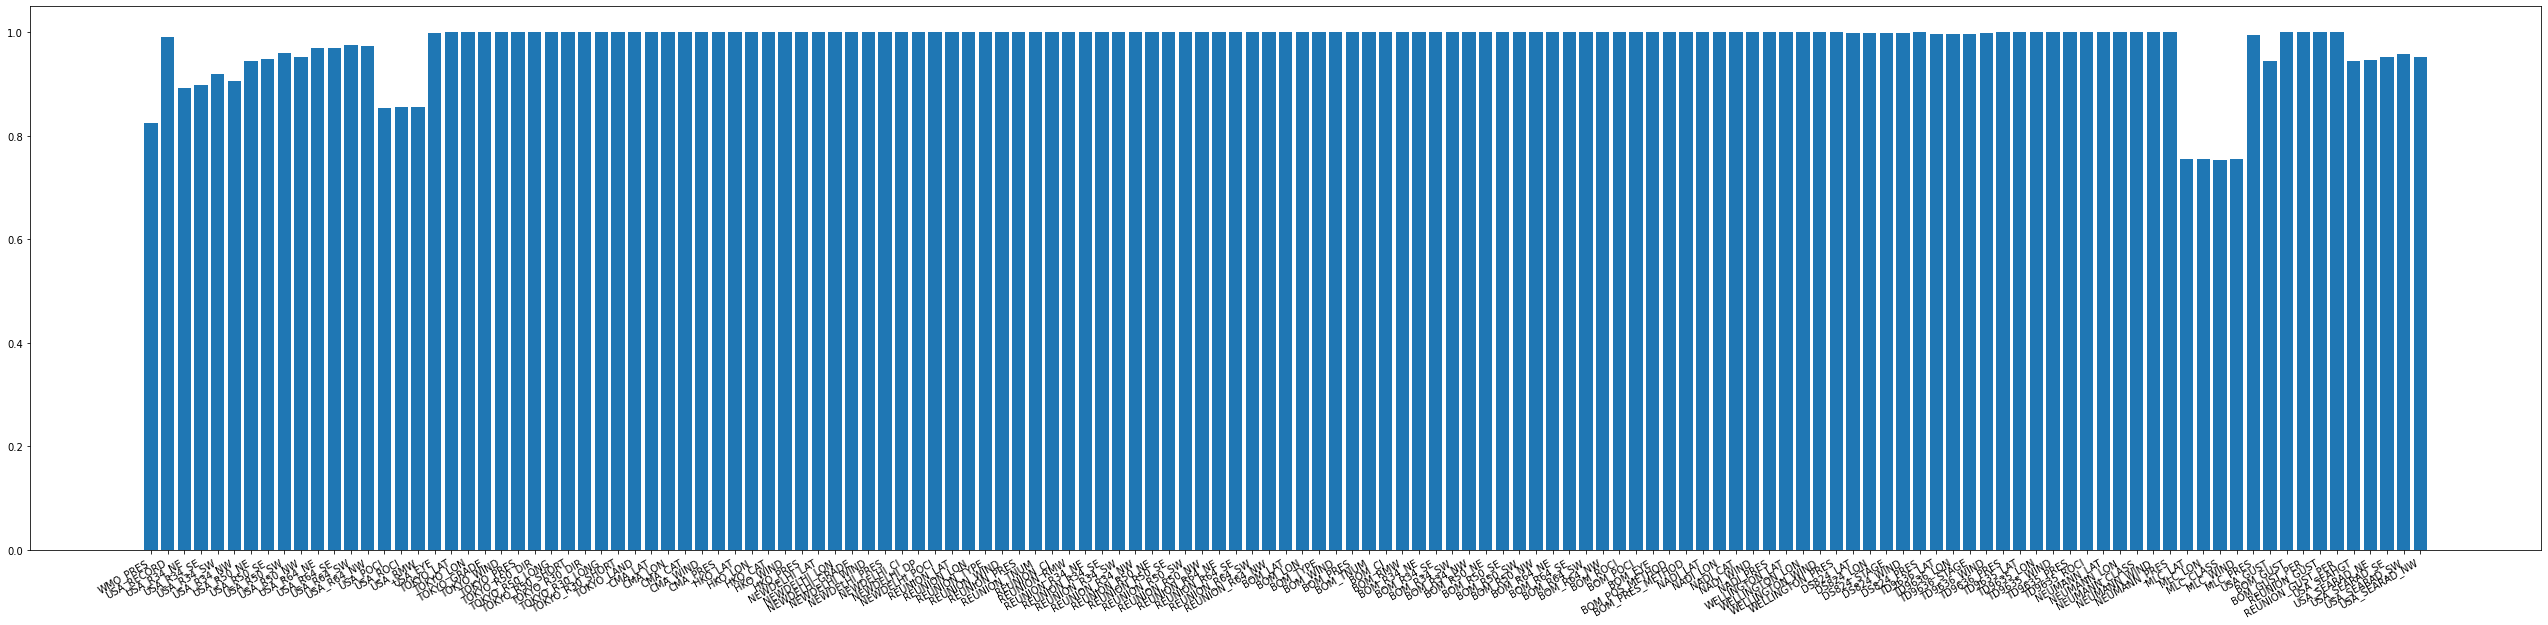

In [ ]:
#plot of the count of columns having all empty values
plt.figure(figsize=(45,10))
plt.xticks(rotation=30, ha='right')
plt.bar(keys, values)

Great revelation here !
We choose to drop all the columns havig more than or equal to 0.7 empty values since they cannot hold any information.

In [ ]:
empty_cols= list(keys)
df.drop(empty_cols, axis =1 , inplace=True)

In [ ]:
df.shape

(124138, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124138 entries, 1 to 124138
Data columns (total 24 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   SID          124138 non-null  object
 1   SEASON       124138 non-null  object
 2   NUMBER       124138 non-null  object
 3   NAME         124138 non-null  object
 4   ISO_TIME     124138 non-null  object
 5   NATURE       124138 non-null  object
 6   LAT          124138 non-null  object
 7   LON          124138 non-null  object
 8   WMO_WIND     124138 non-null  object
 9   WMO_AGENCY   124138 non-null  object
 10  TRACK_TYPE   124138 non-null  object
 11  DIST2LAND    124138 non-null  object
 12  LANDFALL     124138 non-null  object
 13  IFLAG        124138 non-null  object
 14  USA_AGENCY   124138 non-null  object
 15  USA_ATCF_ID  124138 non-null  object
 16  USA_LAT      124138 non-null  object
 17  USA_LON      124138 non-null  object
 18  USA_STATUS   124138 non-null  object
 19  US

##Exploring the remaining 24 columns

##Type Conversion

###Converting Object columns to Int/float

In [ ]:
numeric_cols=['SEASON',	'NUMBER','DIST2LAND','LANDFALL', 'STORM_SPEED',	'STORM_DIR','LAT', 'LON']
df[numeric_cols]=df[numeric_cols].apply(pd.to_numeric, errors='coerce')


###Converting ISO_Time to date time column

In [ ]:
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


In [ ]:
df.head(6)

,SID,SEASON,NUMBER,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,STORM_SPEED,STORM_DIR
1,1851175N26270,1851,5,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,,,main,335,323.0,_____________O,,,,,,,,-5,6.0,291.0
2,1851175N26270,1851,5,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,,,main,323,312.0,_____________P,,,,,,,,-5,6.0,290.0
3,1851175N26270,1851,5,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,,,main,312,302.0,_____________O,,,,,,,,-5,6.0,290.0
4,1851175N26270,1851,5,NOT_NAMED,1851-06-23 21:00:00,TS,26.3999,-91.3001,,,main,304,296.0,_____________P,,,,,,,,-5,6.0,290.0
5,1851175N26270,1851,5,NOT_NAMED,1851-06-24 00:00:00,TS,26.5000,-91.6000,,,main,298,292.0,_____________O,,,,,,,,-5,6.0,290.0
6,1851175N26270,1851,5,NOT_NAMED,1851-06-24 03:00:00,TS,26.5999,-91.9001,,,main,295,292.0,_____________P,,,,,,,,-5,6.0,290.0


We choose to rename SEASON to YEAR. That's more intuitive.




In [ ]:
df.rename(columns={'SEASON': 'YEAR'}, inplace= True, errors='raise')

In [ ]:
print(f"Dataset contains data of {df['SID'].unique().shape[0]} individual storms from {df['YEAR'].min()} to {df['YEAR'].max()}.")

Dataset contains data of 2293 individual storms from 1851 to 2021.


##SID


In [ ]:
ncounts = pd.DataFrame([df.SID.value_counts()]).T
ncounts = ncounts.rename(columns={0: "value_counts_SID"})

In [ ]:
ncounts

,SID
1899215N12329,264
1971249N26289,235
1969264N16313,197
2012255N16322,191
1926244N14319,189
...,...
1865182N26263,1
1853265N20265,1
1854236N33305,1
1853272N15323,1


A unique storm identifier (SID) assigned by IBTrACS algorithm.

We have 2293 different storms.



In [ ]:
import plotly.express as px 
import geopandas as gpd

#plotting the trajectory of the storm having as SID = 1899215N12329
fig = px.scatter_mapbox(df.query(" SID == '1899215N12329' "), lat="LAT", lon="LON", hover_name="YEAR", hover_data=["USA_SSHS"],color='NATURE', zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
import plotly.express as px 
import geopandas as gpd

#plotting the trajectory of the storm having as SID = 1899215N12329
fig = px.scatter_mapbox(df.query(" SID == '2012255N16322' "), lat="LAT", lon="LON", hover_name="YEAR", hover_data=["USA_SSHS"],color='NATURE', zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



As it won't be very useful for the prediction part ➡ we choose to drop it.

In [ ]:
#df.drop('SID', axis=1, inplace=True)

##Nature 


Nature is a categorical column showing the storm nature.

DS - Disturbance

TS - Tropical

ET - Extratropical

SS - Subtropical

NR - Not reported

MX - Mixture (contradicting nature reports from different agencies)

In [ ]:
df.NATURE.value_counts()

TS    105183
ET     12071
DS      3240
SS      2173
NR       983
MX       488
Name: NATURE, dtype: int64

##Vizualising data for the year 2021

In [ ]:
df_2021= df.query(" YEAR == 2021")

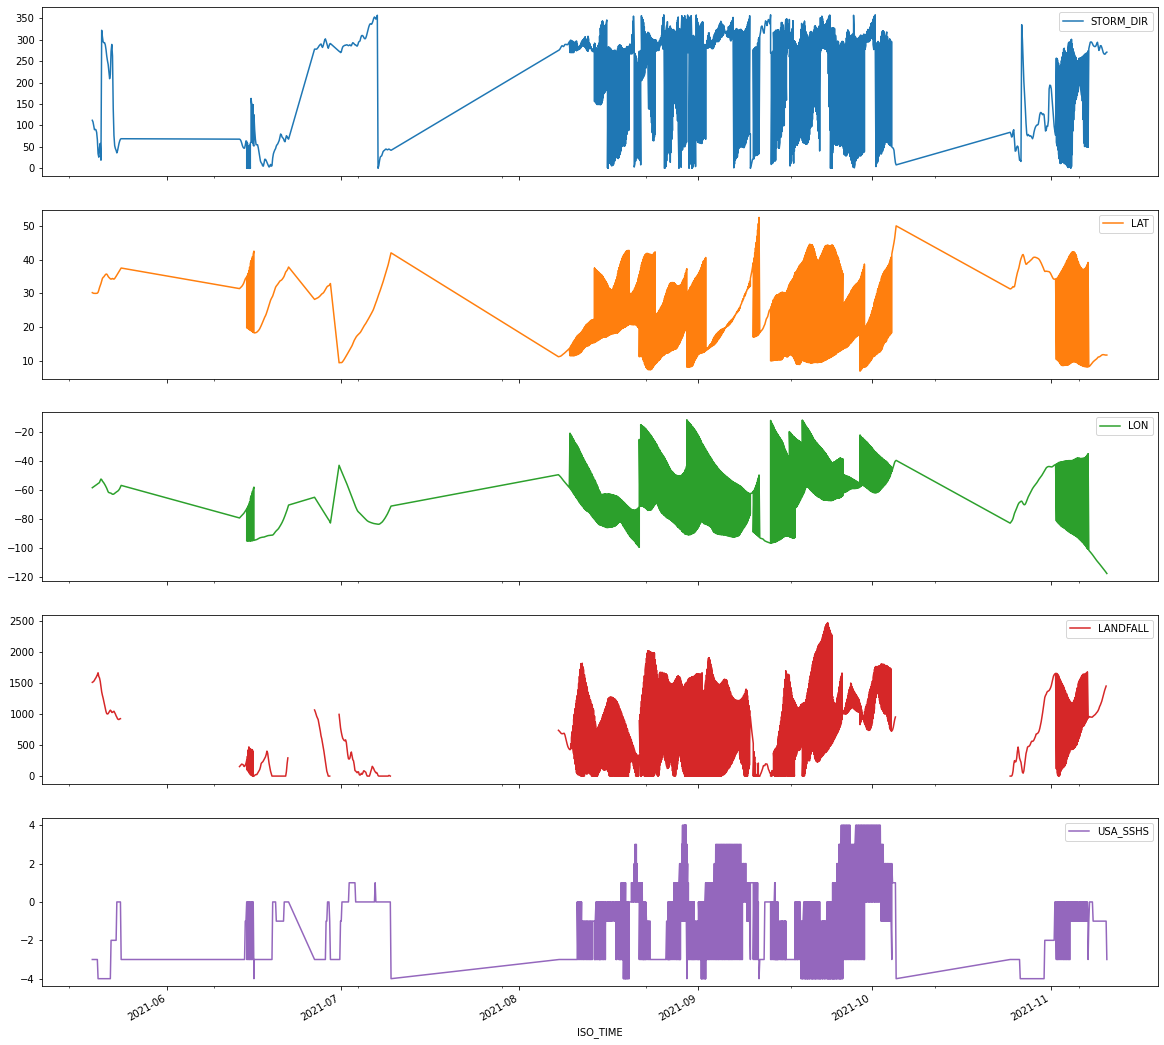

In [ ]:
plot_cols = ['STORM_DIR', 'LAT', 'LON', 'LANDFALL','USA_SSHS']
plot_features = df_2021[plot_cols]
plot_features.index = df_2021.ISO_TIME
_ = plot_features.plot(subplots=True, figsize=(20,20), kind='line')


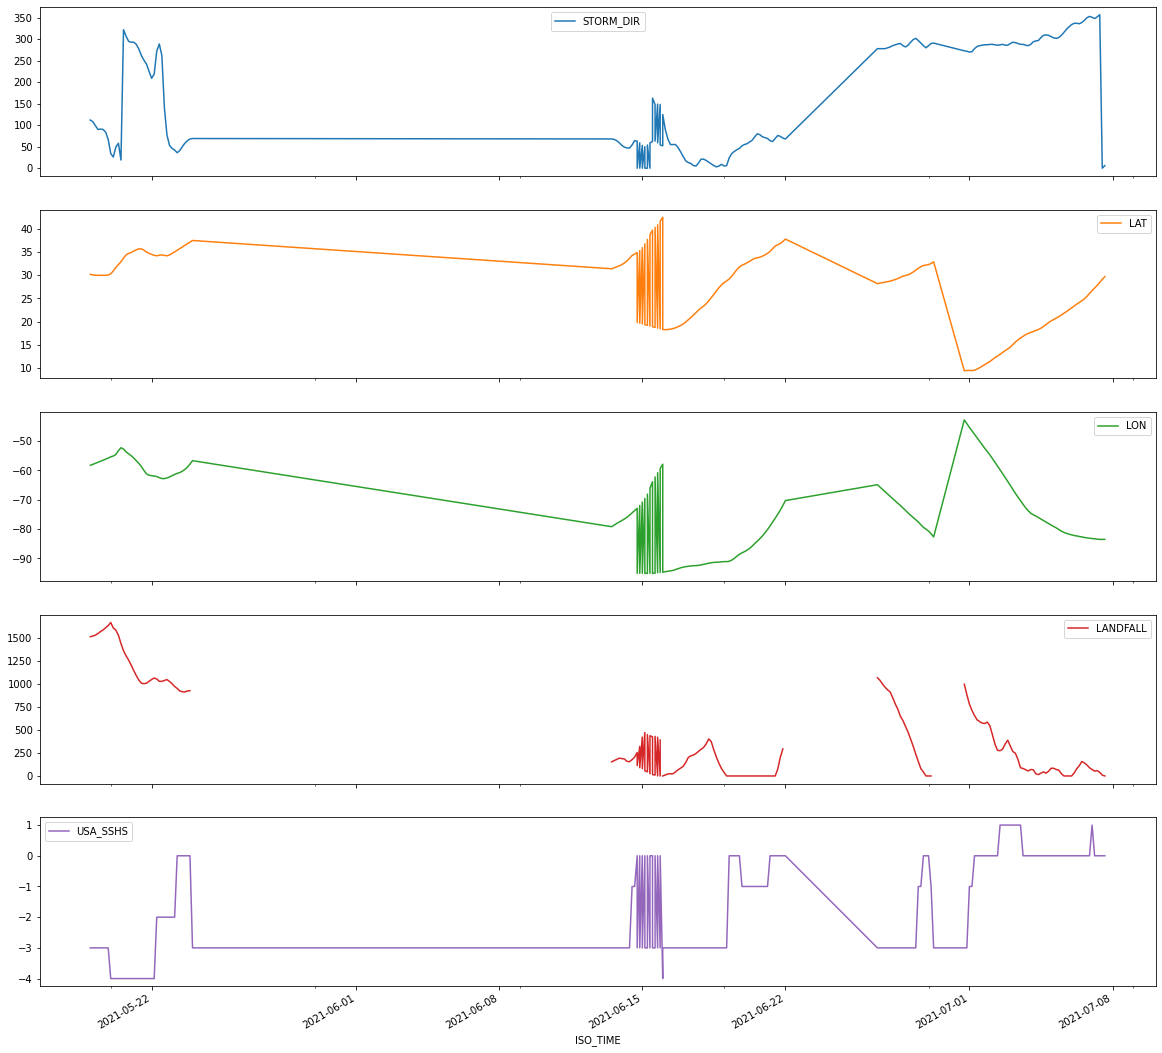

In [ ]:
plot_features = df_2021[plot_cols][:200]
plot_features.index = df_2021.ISO_TIME[:200]
_ = plot_features.plot(subplots=True,  figsize=(20,20))

In [ ]:
df_2021.USA_SSHS

122506   -3
122507   -3
122508   -3
122509   -3
122510   -3
         ..
124134   -1
124135   -1
124136   -1
124137   -1
124138   -3
Name: USA_SSHS, Length: 1633, dtype: int64

In [ ]:
#Plotting the storms of 2021 

fig = px.scatter_mapbox(df_2021, lat="LAT", lon="LON", hover_name="YEAR", hover_data=["USA_SSHS"],color='USA_SSHS', zoom=3, height=600)
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        },
        {
            "sourcetype": "raster",
            "sourceattribution": "Government of Canada",
            "source": ["https://geo.weather.gc.ca/geomet/?"
                       "SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&BBOX={bbox-epsg-3857}&CRS=EPSG:3857"
                       "&WIDTH=1000&HEIGHT=1000&LAYERS=RADAR_1KM_RDBR&TILED=true&FORMAT=image/png"],
        }
      ])
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

This map shows the tracks of all tropical cyclones in the 2020 Atlantic hurricane season.The colour represents our column **USA_SSHS :**

storm's maximum sustained wind speeds as classified in the Saffir-Simpson Hurricane Scale

##Name
Name provided by the agency

In [ ]:
df['NAME'].nunique()

303

In [ ]:
df['NAME'].value_counts(ascending=False)

NOT_NAMED    72416
FLORENCE       642
ARLENE         625
FRANCES        621
HELENE         556
             ...  
SIMONE          19
SHARY           17
TAMMY           16
IMELDA          14
AMELIA          11
Name: NAME, Length: 303, dtype: int64

The majority values **58% = 72416/df.shape[0]** of Name are missing 'NOT NAMED' ➡ drop the column 

In [ ]:
df.drop('NAME', axis=1, inplace=True)

##Year 


In [ ]:
df.YEAR.value_counts(ascending=True)

1914      36
1925     132
1907     198
1919     242
1920     252
        ... 
1995    1481
2021    1633
2020    1699
2005    1807
1887    1907
Name: YEAR, Length: 171, dtype: int64

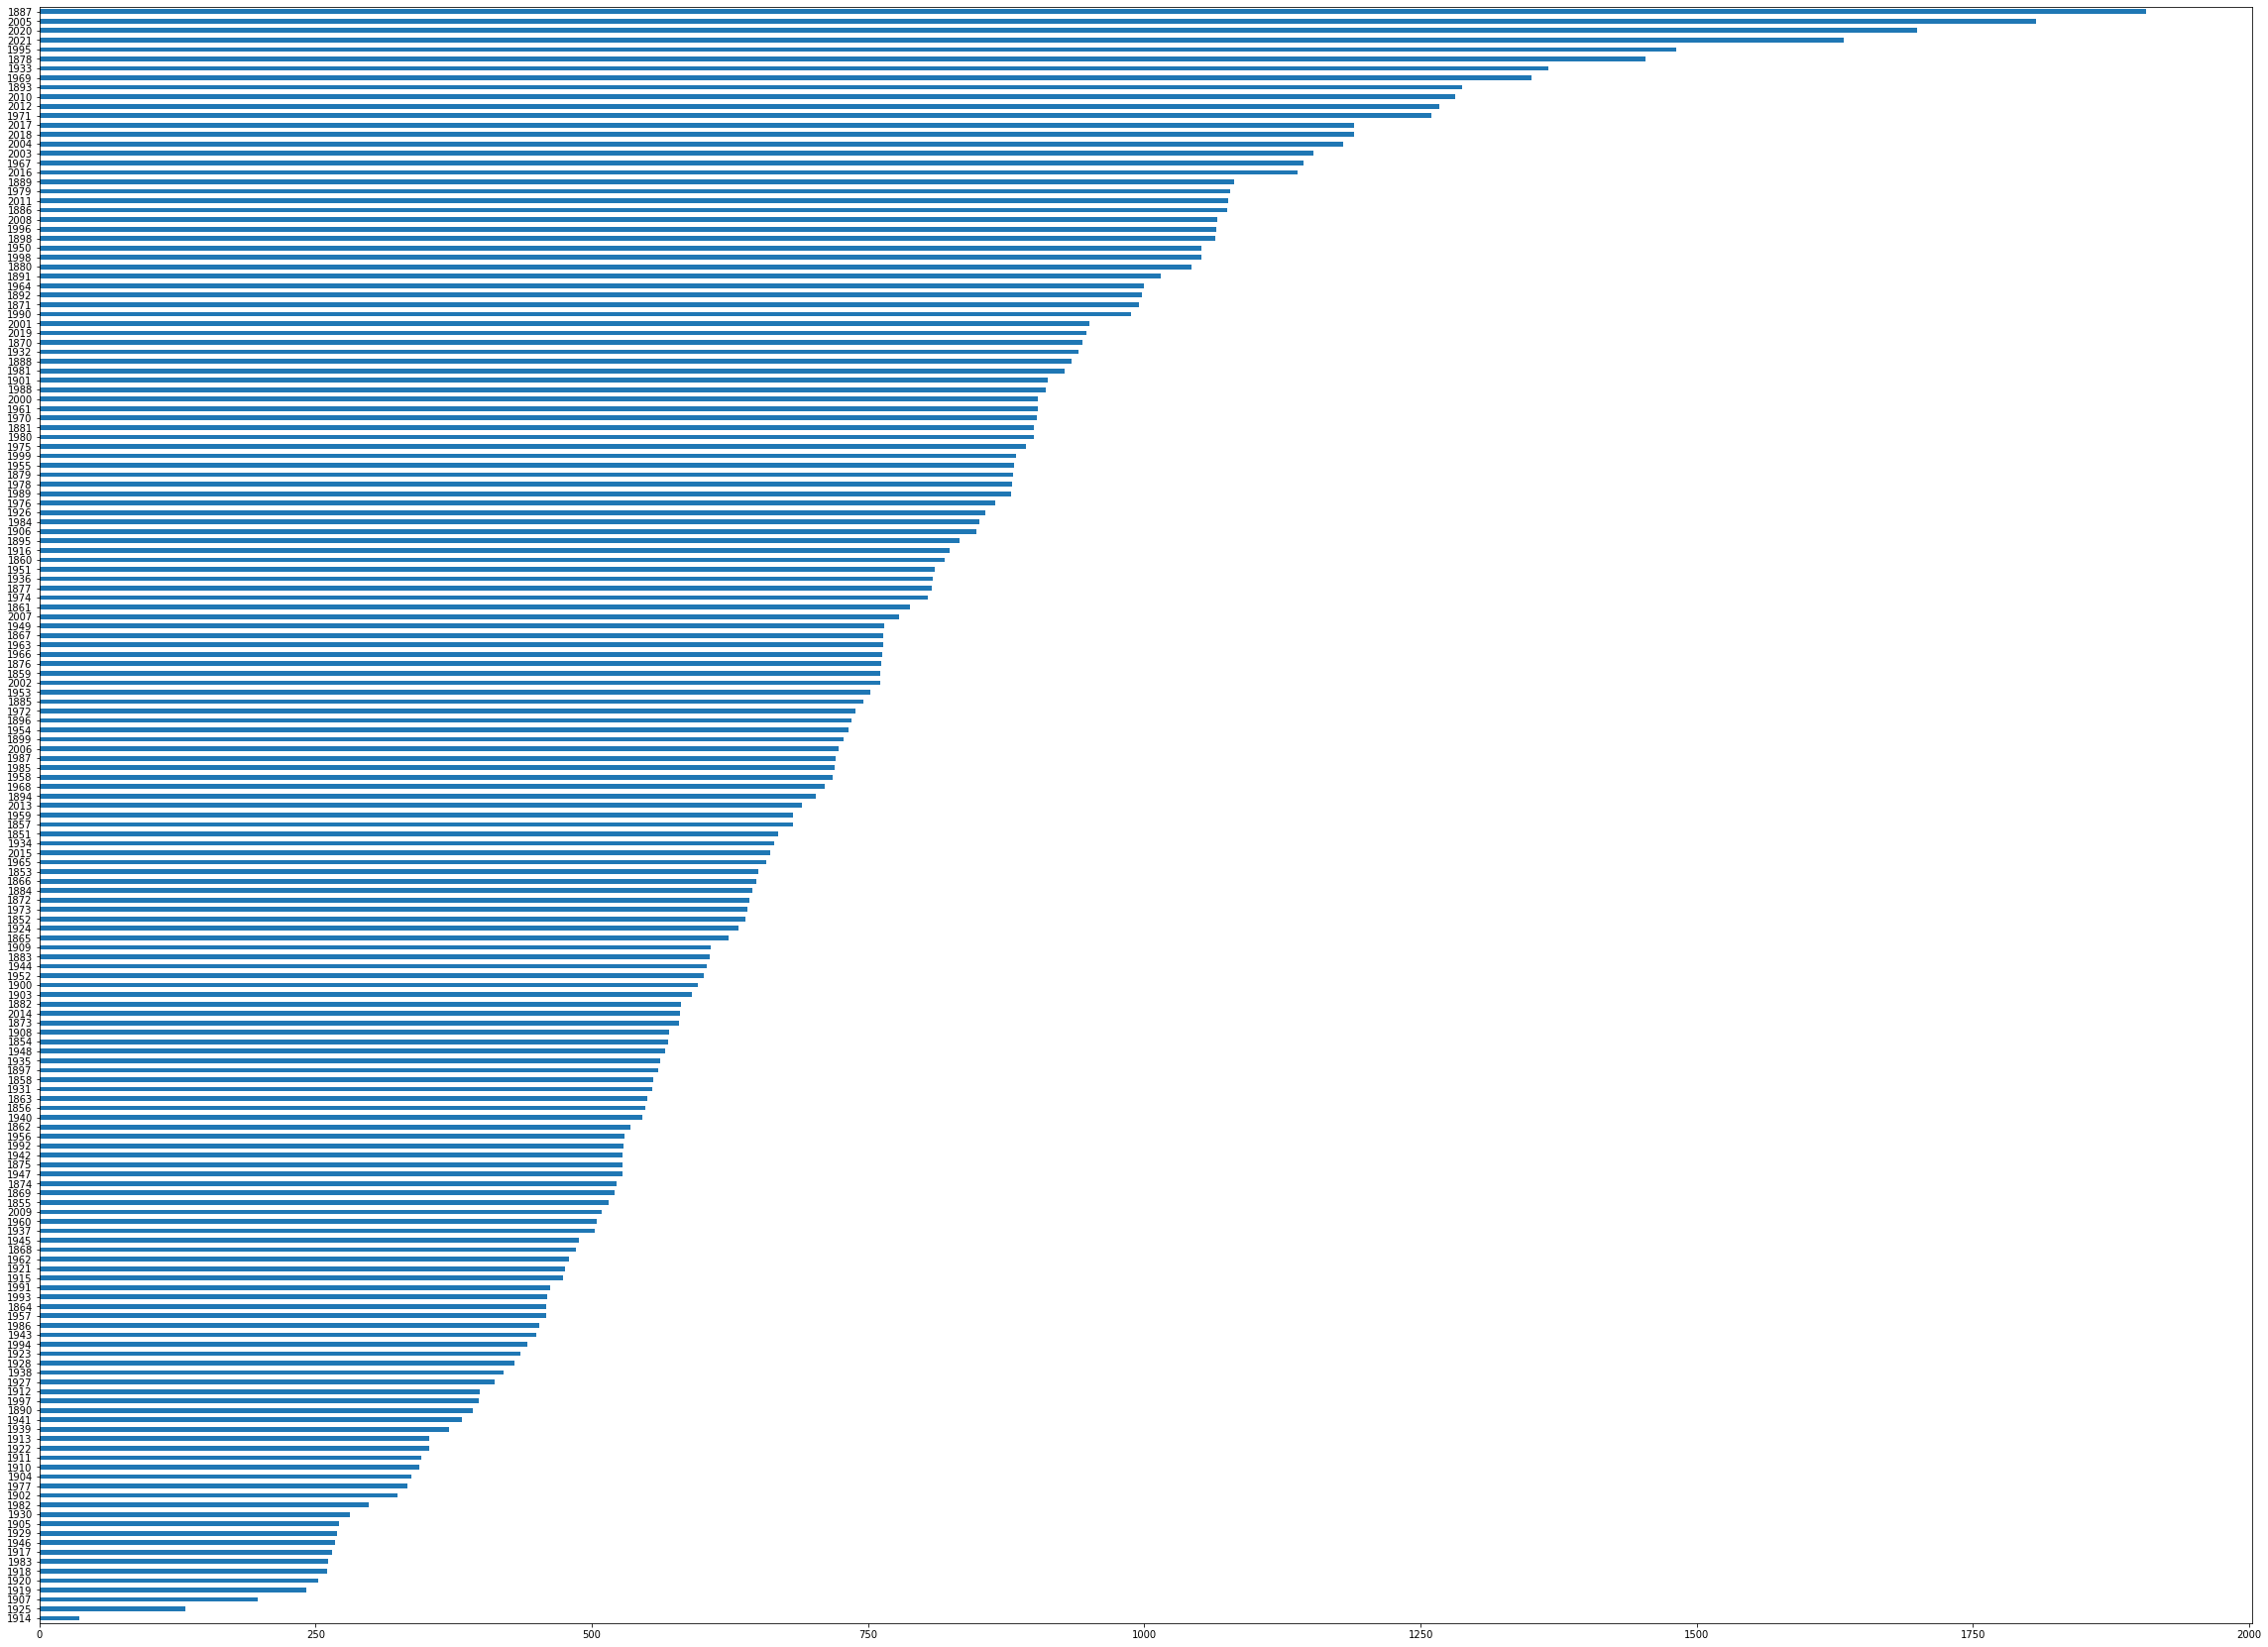

In [ ]:
df.YEAR.value_counts().sort_values().plot(kind = 'barh',figsize=(40,30))


##Missing values

In [ ]:
df.isnull().sum()

SID               0
YEAR              0
NUMBER            0
ISO_TIME          0
NATURE            0
LAT               0
LON               0
WMO_WIND          0
WMO_AGENCY        0
TRACK_TYPE        0
DIST2LAND         0
LANDFALL       2293
IFLAG             0
USA_AGENCY        0
USA_ATCF_ID       0
USA_LAT           0
USA_LON           0
USA_STATUS        0
USA_WIND          0
USA_PRES          0
USA_SSHS          0
STORM_SPEED      29
STORM_DIR        29
dtype: int64

**Hypothesis :**

Verify if the rows having null values for STORM_SPEED and STORM_DIR are the same since they have both 29 missing values.

It is suspicious.


In [ ]:
df[df['STORM_SPEED'].isna() & df['STORM_DIR'].isna()].shape


(29, 23)

**Conclusion**

Exactly, the same rows have both NaNs for STORM_SPEED and STORM_DIR.

That's why we can delete the rows containing these missing values.

In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.isnull().sum()

SID            0
YEAR           0
NUMBER         0
ISO_TIME       0
NATURE         0
LAT            0
LON            0
WMO_WIND       0
WMO_AGENCY     0
TRACK_TYPE     0
DIST2LAND      0
LANDFALL       0
IFLAG          0
USA_AGENCY     0
USA_ATCF_ID    0
USA_LAT        0
USA_LON        0
USA_STATUS     0
USA_WIND       0
USA_PRES       0
USA_SSHS       0
STORM_SPEED    0
STORM_DIR      0
dtype: int64

## USA_SSHS

-5 = Unknown [XX]

-4 = Post-tropical [EX, ET, PT]

-3 = Miscellaneous disturbances [WV, LO, DB, DS, IN, MD]

-2 = Subtropical [SS, SD]

Tropical systems classified based on wind speeds [TD, TS, HU, TY,, TC, ST, HR]

 -1 = Tropical depression (W<34)

 0 = Tropical storm [34<W<64]

 1 = Category 1 [64<=W<83]

 2 = Category 2 [83<=W<96]

 3 = Category 3 [96<=W<113]
 
 4 = Category 4 [113<=W<137]

 5 = Category 5 [W >= 137]


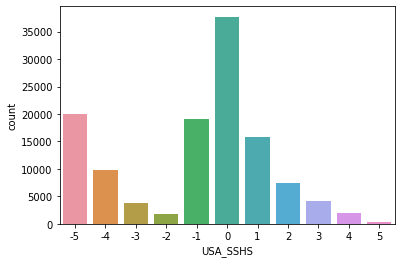

In [ ]:
# count plot on single categorical variable
sns.countplot(x ='USA_SSHS', data = df)
# Show the plot
plt.show()

Unbalanced distribution of the values of USA_SSHS

#Feature engineering

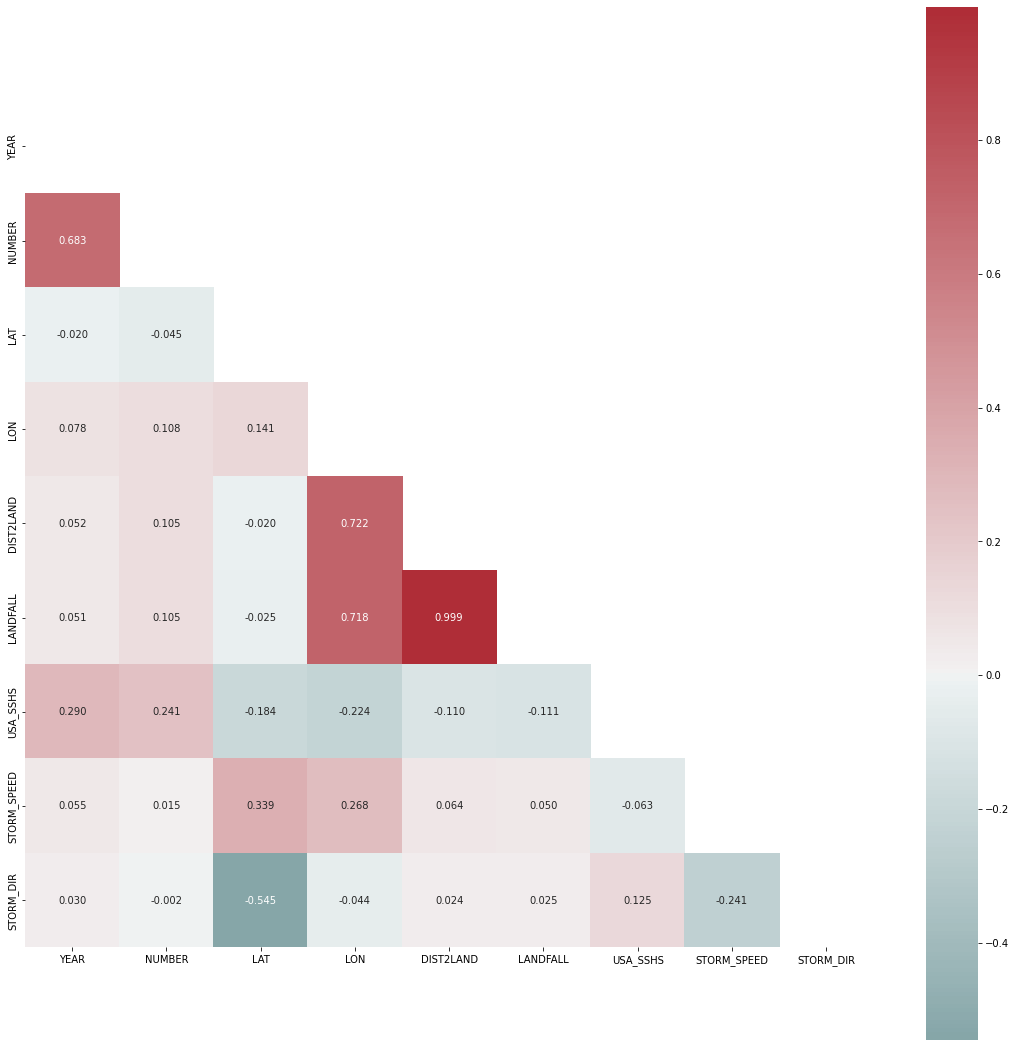

In [ ]:
#Correlation matrix
matrix = df.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(200, 10, s=75, l=40,
                            n=9, center="light", as_cmap=True)

plt.figure(figsize=(19, 19))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
            fmt='.3f', square=True, cmap=cmap)

plt.show();



1. Here we note that season is highly correlated with the Number which is obvious given the information that : 

      ▶ Number is The cardinal number of the system for that season.

      ▶ Season is the year

2. We note that we are having exactly 2 redundant columns.

  Let's verify if they are equal element wise or one is the result of a calculation of the other.

 

In [ ]:
#verifying if they are equal element-wise 
df['DIST2LAND'].equals(df['LANDFALL'])


False

Conclusion : 

One Column is the result of a calculation of the other.

We could just maintain the most correlated with the target.

In [ ]:
df.drop(columns=['NUMBER','DIST2LAND'], axis =1, inplace=True)

#Modeling 

This is a case of multivariate Time series because it consists of more than one time-dependent variable and each variable depends not only on its past values but also has some dependency on other variables.

Here in the modeling part we worked on predicting the trajectory so we are limiting our dataframe only on the longitude and latitude.

In [ ]:
df.set_index(df['ISO_TIME'], inplace=True)

In [ ]:
df=df[['LAT','LON']]

In [ ]:
df.head(4)

,LAT,LON
ISO_TIME,,
1851-06-23 12:00:00,26.1000,-90.4000
1851-06-23 15:00:00,26.2001,-90.6999
1851-06-23 18:00:00,26.3000,-91.0000
1851-06-23 21:00:00,26.3999,-91.3001


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121845 entries, 1851-06-23 12:00:00 to 2021-11-10 15:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   LAT     121845 non-null  float64
 1   LON     121845 non-null  float64
dtypes: float64(2)
memory usage: 2.8 MB


In [ ]:
df=df.apply(pd.to_numeric, errors='coerce')


##Testing stationarity :ADF Test




In [ ]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['LAT'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -35.850949
p-value                      0.000000
# lags used                 71.000000
# observations          121773.000000
critical value (1%)         -3.430404
critical value (5%)         -2.861564
critical value (10%)        -2.566783
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
adf_test(df['LON'])

Augmented Dickey-Fuller Test: 
ADF test statistic         -36.201758
p-value                      0.000000
# lags used                 42.000000
# observations          121802.000000
critical value (1%)         -3.430404
critical value (5%)         -2.861564
critical value (10%)        -2.566783
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##Testing Causation: Granger’s Causality Test

In [ ]:
df.head()

,LAT,LON
ISO_TIME,,
1851-06-23 12:00:00,26.1000,-90.4000
1851-06-23 15:00:00,26.2001,-90.6999
1851-06-23 18:00:00,26.3000,-91.0000
1851-06-23 21:00:00,26.3999,-91.3001
1851-06-24 00:00:00,26.5000,-91.6000


In [ ]:
print('LAT causes LON?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['LON', 'LAT']], 4)

print('\nLON causes LAT?\n')
print('------------------')
granger_2 = grangercausalitytests(df[['LAT', 'LON']], 4)

LAT causes LON?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=222.8921, p=0.0000  , df_denom=121841, df_num=1
ssr based chi2 test:   chi2=222.8975, p=0.0000  , df=1
likelihood ratio test: chi2=222.6939, p=0.0000  , df=1
parameter F test:         F=222.8921, p=0.0000  , df_denom=121841, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=106.2008, p=0.0000  , df_denom=121838, df_num=2
ssr based chi2 test:   chi2=212.4104, p=0.0000  , df=2
likelihood ratio test: chi2=212.2254, p=0.0000  , df=2
parameter F test:         F=106.2008, p=0.0000  , df_denom=121838, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=68.0954 , p=0.0000  , df_denom=121835, df_num=3
ssr based chi2 test:   chi2=204.2981, p=0.0000  , df=3
likelihood ratio test: chi2=204.1270, p=0.0000  , df=3
parameter F test:         F=68.0954 , p=0.0000  , df_denom=121835, df_num=3

Granger Causality
number of lags (no ze

Plotting PACF

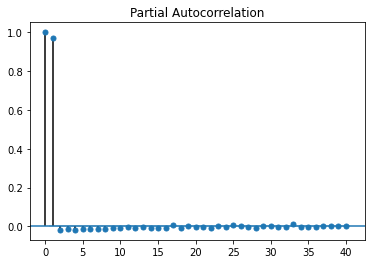

In [ ]:
plot_pacf(df['LON'],lags=40)
plt.show()

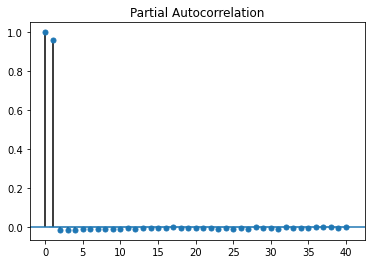

In [ ]:
plot_pacf(df['LAT'],lags=40)
plt.show()

##Correlation between "LON" and lagged "LAT"


In [ ]:
from scipy.stats import pearsonr

for lag in range(1, 40):
    LON_series = df['LON'].iloc[lag:]
    lagged_LAT_series = df['LAT'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(LON_series, lagged_LAT_series))
    print('------')

Lag: 1
(0.1464859228392891, 0.0)
------
Lag: 2
(0.15180280633602233, 0.0)
------
Lag: 3
(0.15652136028526098, 0.0)
------
Lag: 4
(0.16059351906787656, 0.0)
------
Lag: 5
(0.16408475121385963, 0.0)
------
Lag: 6
(0.16701342732602315, 0.0)
------
Lag: 7
(0.1693848894656813, 0.0)
------
Lag: 8
(0.17116409757673695, 0.0)
------
Lag: 9
(0.1723897433799365, 0.0)
------
Lag: 10
(0.1731213465000585, 0.0)
------
Lag: 11
(0.17334018599439383, 0.0)
------
Lag: 12
(0.17316127211612553, 0.0)
------
Lag: 13
(0.1726783363382467, 0.0)
------
Lag: 14
(0.17182722762871488, 0.0)
------
Lag: 15
(0.1706981882852519, 0.0)
------
Lag: 16
(0.16925104365795807, 0.0)
------
Lag: 17
(0.1674231473174776, 0.0)
------
Lag: 18
(0.1653094498882035, 0.0)
------
Lag: 19
(0.1630311858273946, 0.0)
------
Lag: 20
(0.1605979533948303, 0.0)
------
Lag: 21
(0.15805691451601606, 0.0)
------
Lag: 22
(0.15526554830837225, 0.0)
------
Lag: 23
(0.15262018985027598, 0.0)
------
Lag: 24
(0.14975890751260057, 0.0)
------
Lag: 25
(0.

Lag 37 is intersting when we want to predict longitude using the lagged column of latitude.

In [ ]:
df.tail(15)

,LAT,LON
ISO_TIME,,
2021-11-08 21:00:00,10.4136,-108.098
2021-11-09 00:00:00,10.6000,-108.700
2021-11-09 03:00:00,10.8686,-109.275
2021-11-09 06:00:00,11.1000,-109.850
2021-11-09 09:00:00,11.1612,-110.468
2021-11-09 12:00:00,11.2000,-111.100
2021-11-09 15:00:00,11.3636,-111.729
2021-11-09 18:00:00,11.5500,-112.350
2021-11-09 21:00:00,11.7010,-112.943


In [ ]:
train_df = df.iloc[df.index.year != 2021]


In [ ]:
train_df.shape

(120234, 2)

In [ ]:
test_df = df.iloc[df.index.year == 2021]

In [ ]:
test_df.shape

(1611, 2)

In [ ]:
model = VAR(train_df)


In [ ]:
model_fit = model.fit(maxlags=37)


In [ ]:
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 13, Feb, 2022
Time:                     22:05:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.10567
Nobs:                     120197.    HQIC:                   5.09721
Log likelihood:          -647070.    FPE:                    162.971
AIC:                      5.09357    Det(Omega_mle):         162.768
--------------------------------------------------------------------
Results for equation LAT
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           1.023962         0.050589           20.241           0.000
L1.LAT          0.971811         0.002939          330.695           0.000
L1.LON         -0.007301         0.001783           -4.095           0.000
L2.LAT     

In [ ]:
sorted_order=model.select_order(maxlags=37)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        10.55       10.55   3.826e+04       10.55
1        5.095       5.096       163.2       5.095
2        5.095      5.096*       163.2       5.095
3        5.094       5.096       163.1       5.095
4        5.094       5.096       163.1       5.095
5        5.094       5.096       163.0       5.095
6        5.094       5.096       163.0       5.094
7        5.094       5.096       163.0       5.094
8        5.094       5.096       163.0      5.094*
9        5.093       5.097       163.0       5.094
10       5.093       5.097       162.9       5.094
11       5.093       5.097       162.9       5.095
12       5.093       5.097       162.9       5.095
13       5.093       5.098       162.9       5.095
14       5.093       5.098       162.9       5.095
15       5.093       5.098       162.9       5.095
16       5.093       5.099     

In [ ]:
var_model = VARMAX(train_df, order=(1,1),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

We noticed that Most points are provided at 3 hour intervals.
So we need to choose to forecast on the follwing 8 intervals which corespond to 24 hours

In [ ]:
#predicting 24hours ahead.
n_forecast = 8
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)
predictions=predict.predicted_mean

In [ ]:
predictions.columns=['LAT_predicted','LON_predicted']
predictions

,LAT_predicted,LON_predicted
120234,14.427615,-87.948574
120235,15.075638,-87.490425
120236,15.694809,-87.033221
120237,16.286290,-86.577496
120238,16.851200,-86.123745
120239,17.390618,-85.672424
120240,17.905579,-85.223959
120241,18.397083,-84.778740


##Plot the forcast vs real data

In [ ]:
predictions.plot(figsize=(12,5), legend=True, title = 'Latitude and Longitude predicted for the next 24 hours')
test_df[:8].plot(figsize=(12,5), legend=True, title='Real values of latitude and Longitude for the next 24 hours')


NameError: ignored

In [ ]:
rmse_LAT=math.sqrt(mean_squared_error(predictions['LAT_predicted'],test_df['LAT'][:8]))
print('Mean value of LAT is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['LAT']),rmse_LAT))

rmse_LON=math.sqrt(mean_squared_error(predictions['LON_predicted'],test_df['LON'][:8]))
print('Mean value of LON is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['LON']),rmse_LON))

Mean value of LAT is : 23.72595069522036. Root Mean Squared Error is :13.598988350189645
Mean value of LON is : -61.30389186840472. Root Mean Squared Error is :29.286506775084
